# ENSO

## Purpose:
Compute and plot the ENSO variability and nin3.4 index.

## Acknowledgment:
This notebook builds on work by John Krasting (https://github.com/jkrasting/mar/blob/main/src/gfdlnb/notebooks/ocean/ENSO.ipynb) and a tutorial provided by the Project Pythia (https://foundations.projectpythia.org/core/xarray/enso-xarray.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import numpy as np
import xarray as xr
import momlevel as ml
import xwavelet as xw
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import cime_xmlquery
from mom6_tools.m6toolbox import add_global_attrs
from mom6_tools.enso import plot_enso_obs
from mom6_tools.m6toolbox import  geoslice
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import yaml, os, intake, pickle

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', casename)

Output directory is: /glade/derecho/scratch/gmarques/archive/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/ocn/hist/
Casename is: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079


In [5]:
# The following parameters must be set accordingly
# create an empty class object
class args:
  pass

args.infile = OUTDIR
args.native = casename+diag_config_yml['Fnames']['native']
args.static = casename+diag_config_yml['Fnames']['static']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.year_shift = 0 #1957 # Option to shift by args.year_shift years
args.casename = casename
args.label = diag_config_yml['Case']['SNAME']
args.savefigs = False

In [6]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)

try:
  depth = grd.depth_ocean
except:
  depth = grd.deptho

MOM6 grid successfully loaded... 



In [7]:
cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.105:44673,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load model data

In [8]:
def preprocess(ds):
    ''' Return a dataset desired variables'''
    variables = ['tos']
    return ds[variables]

In [9]:
print('\n Reading dataset...')
# load data
%time ds = xr.open_mfdataset(OUTDIR+'/'+args.native, parallel=True, \
                             combine="nested", concat_dim="time", \
                             preprocess=preprocess).chunk({"time": 12})


 Reading dataset...
CPU times: user 2.66 s, sys: 134 ms, total: 2.8 s
Wall time: 22.3 s


In [10]:
# Add the latitude and longitude as new coordinates to the pv DataArray
ds = ds.assign_coords({
    "latitude": (("yh", "xh"), grd.geolat.data),
    "longitude": (("yh", "xh"), grd.geolon.data),
    "areacello": (("yh", "xh"), grd.areacello.fillna(0.).data)
})
#ds

In [11]:
# Nino3.4 SST
nino34 = geoslice(ds.tos,y=(-5,5),x=(-170,-120),
                          xcoord="longitude", ycoord="latitude")
#nino34

### Check the nino3.4 region

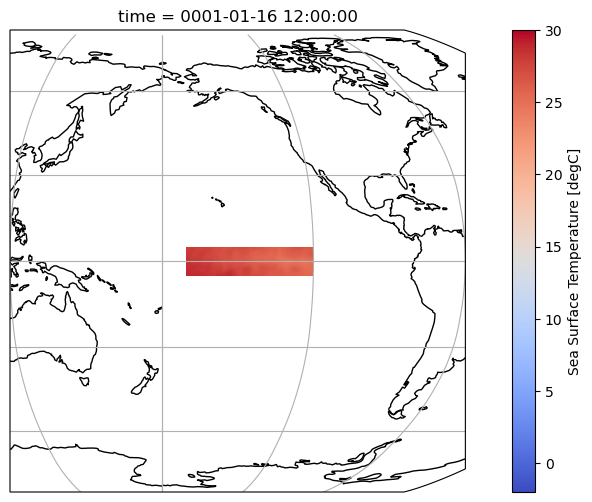

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
nino34.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
)
ax.set_extent((120, 300, 10, -10))

### Compute index

In [13]:
gb = nino34.groupby('time.month')
nino34_anom = gb - gb.mean(dim='time')
index_nino34_model = nino34_anom.weighted(nino34.areacello).mean(dim=['yh', 'xh'])

In [14]:
index_nino34_model_rolling_mean = index_nino34_model.rolling(time=5, center=True).mean()

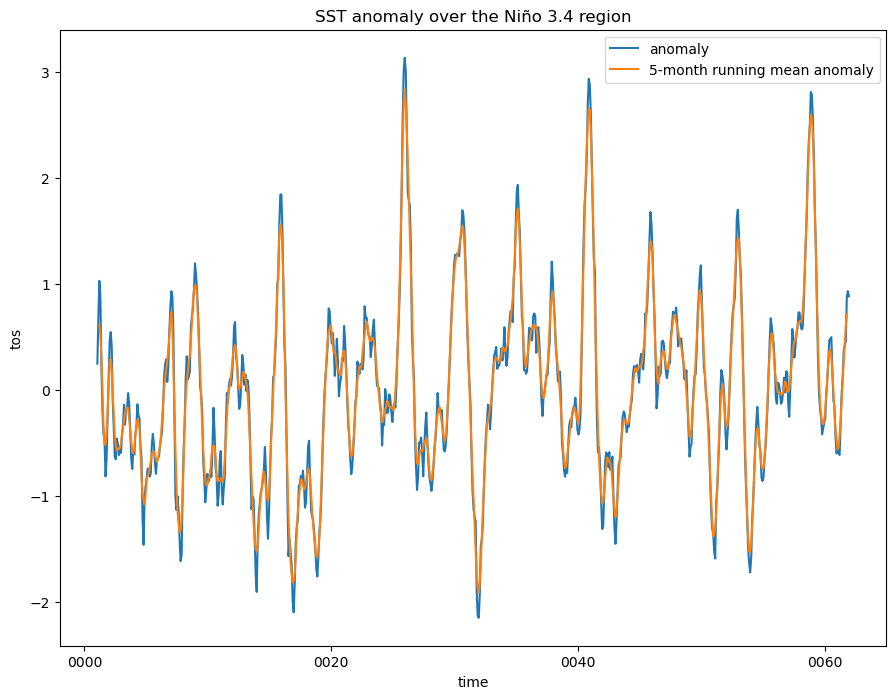

In [15]:
index_nino34_model.plot(size=8)
index_nino34_model_rolling_mean.plot()
plt.legend(['anomaly', '5-month running mean anomaly'])
plt.title('SST anomaly over the Niño 3.4 region');

In [16]:
std_dev_model = nino34.std()
#std_dev_model

In [17]:
# normalize by std
normalized_index_nino34_model_rolling_mean = index_nino34_model_rolling_mean / std_dev_model

In [19]:
#Apply the Conditions to Create the New Data Array
# Define conditions
conditions = [
  normalized_index_nino34_model_rolling_mean >= 0.4,
  normalized_index_nino34_model_rolling_mean <= -0.4
]

x = normalized_index_nino34_model_rolling_mean.time.data
# Define corresponding values
values = [1, -1]
# Apply conditions
index = np.select(conditions, values, default=0)
# Create DataArray
nino34_index = xr.DataArray(
  index,
  coords=[('time',x)],
  name='nino34_index'
)

# Add the DataArray to the Dataset
normalized_index_nino34_model_rolling_mean['nino34_index'] = nino34_index

### Shift time coordinate to align with forcing dataset (optional)

In [20]:
if args.year_shift > 0:
    time = normalized_index_nino34_model_rolling_mean.time.data
    shifted_time = [t.replace(year=t.year + args.year_shift) for t in time]
    # Convert back to xarray coordinate if needed
    time_shifted = xr.DataArray(shifted_time, dims=["time"], name="shifted_time")
    normalized_index_nino34_model_rolling_mean['time'] = time_shifted

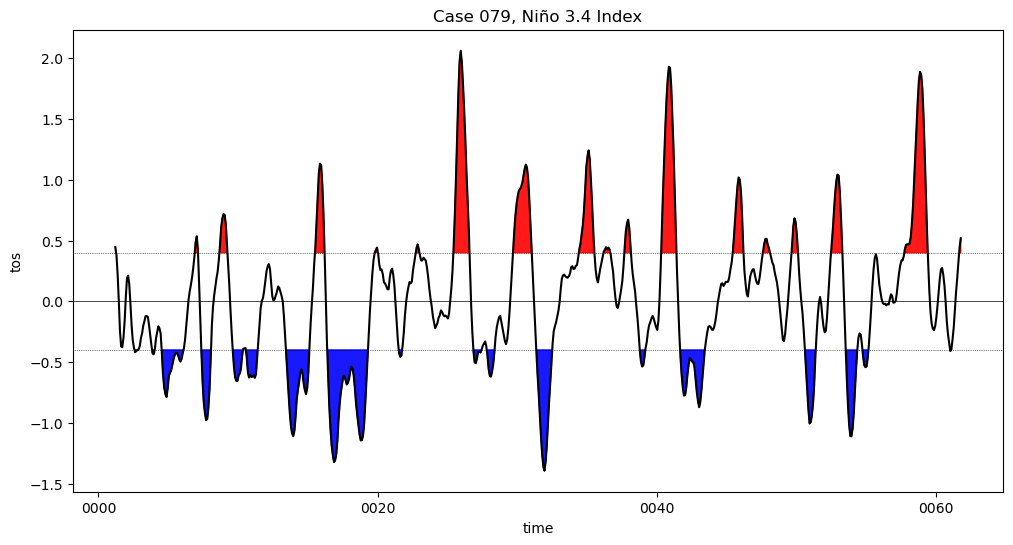

In [21]:
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    normalized_index_nino34_model_rolling_mean.time.data,
    normalized_index_nino34_model_rolling_mean.where(
        normalized_index_nino34_model_rolling_mean >= 0.4
    ),
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    normalized_index_nino34_model_rolling_mean.time.data,
    normalized_index_nino34_model_rolling_mean.where(
        normalized_index_nino34_model_rolling_mean <= -0.4
    ),
    -0.4,
    color='blue',
    alpha=0.9,
)

normalized_index_nino34_model_rolling_mean.plot(color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.title('Case {}, Niño 3.4 Index'.format(args.label));

In [22]:
description = 'Nino 3.4 index'
attrs = {'description': description,
        }
add_global_attrs(normalized_index_nino34_model_rolling_mean,attrs)

In [23]:
print('Saving netCDF files...')
if not os.path.isdir('ncfiles'):
  os.system('mkdir ncfiles')
normalized_index_nino34_model_rolling_mean.to_netcdf('ncfiles/'+str(args.casename)+'_nino34_index.nc')

Saving netCDF files...


### Compute composite

In [24]:
nino34 = nino34.weighted(nino34.areacello).mean(("yh","xh"))
nino34 = nino34.load()

In [25]:
result_model = xw.Wavelet(nino34, scaled=True)

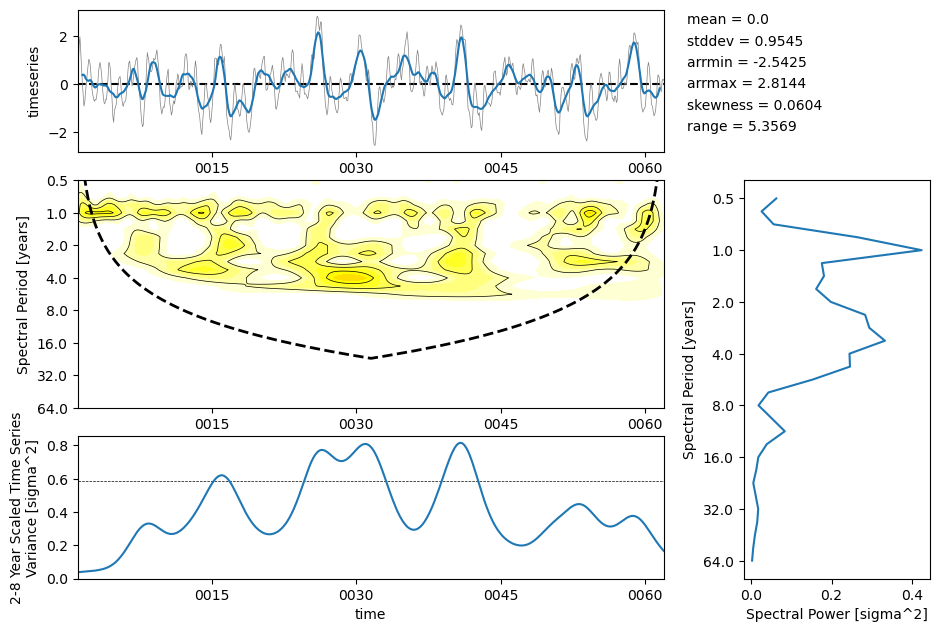

In [26]:
fig = result_model.composite()

In [27]:
# save composite into a pickle file
fname = "ncfiles/" + str(args.casename)+'_nino34_composite.pkl'
with open(fname, "wb") as file:
    pickle.dump(result_model, file)

In [28]:
# This is how the pickle file can be loaded and plotted
#with open("../result_model.pkl", "rb") as file:
#    loaded_obj = pickle.load(file)

#fig = loaded_obj.composite()

## ENSO in OiSSTv2

In [29]:
# load obs-based sst from oce-catalog
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
obs = catalog['oisstv2-tx2_3v2'].to_dask()
obs = obs.assign_coords({
    "areacello": (("yh", "xh"), grd.areacello.fillna(0.).data)
  })
obs

<xarray.Dataset> Size: 466MB
Dimensions:    (time: 444, yh: 480, xh: 540)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1982-01-16 ... 2018-12-16
    geolat     (yh, xh) float64 2MB dask.array<chunksize=(480, 540), meta=np.ndarray>
    geolon     (yh, xh) float64 2MB dask.array<chunksize=(480, 540), meta=np.ndarray>
    areacello  (yh, xh) float32 1MB 0.0 0.0 0.0 ... 3.986e+07 4.974e+06
Dimensions without coordinates: yh, xh
Data variables:
    sst        (time, yh, xh) float32 460MB dask.array<chunksize=(444, 480, 540), meta=np.ndarray>

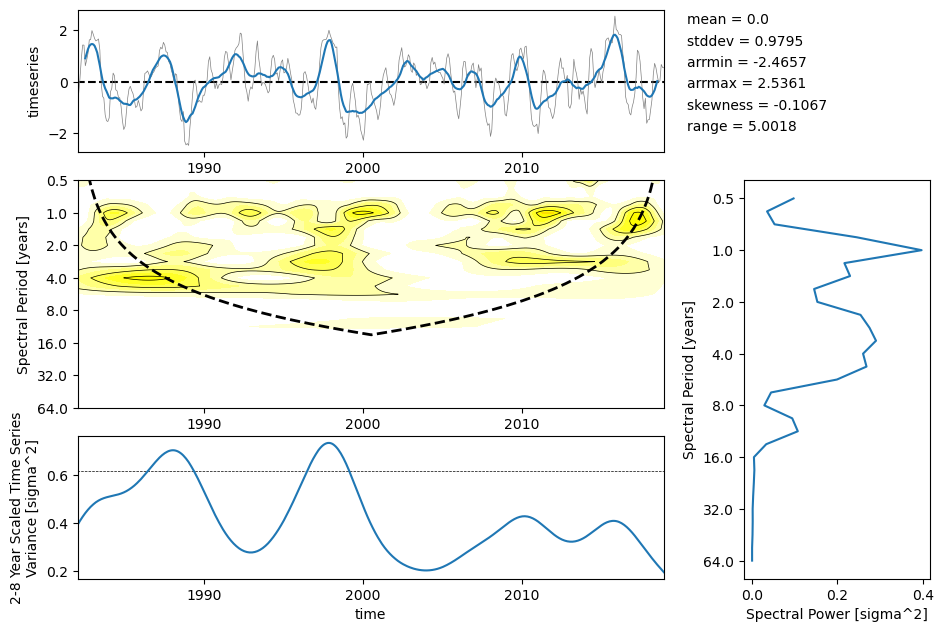

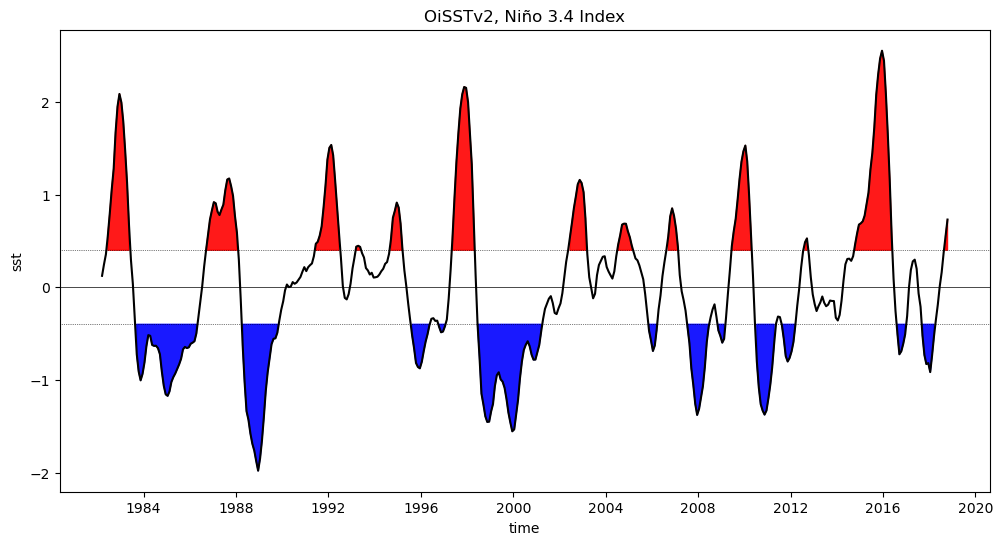

In [30]:
plot_enso_obs(obs)